<a href="https://colab.research.google.com/github/thulasi-bikku/Classification/blob/main/Organic_Comparative_With_and_Without_Binning_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objectives:Here we have considered Organic Dataset (Refractive Index Website) and applied Random Forest using Binning (Divided entire dataset into 10 equal parts) and without Binning. 

### Getting Started:
- Colab notebooks consist of text cells (like this one) and program code cells, like the one shown below. Code cells are executed by typing the Cmd+Enter keys (or Ctrl-Enter). You can also execute a code cell by mousing over the [ ] symbol in the upper left hand side of the code cell---when you hover over it it will turn into a "play" button, and clicking the play button will execute the code cell. You can find other options for executing groups of cells in the "Runtime" menu above.

- Start by executing the code cell below (the one that begins with the line import pandas as pd). This loads ("imports") the required software modules that will be used in the assignment.
## Loading Python Libraries

In [ ]:
#load the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from scipy import stats
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Take a moment to look at this code block:
- import loads a module
- import ... as allows you to assign a short alias to the module
- from ... import loads a small portion of a module
- observe that the import, as and from keywords are color coded purple.
indicates a comment (observe that all of the text following the # is color coded green). This text is not interpreted by the computer, and its goal is to provide the human with some information about what is happening.<BR><BR>
What do each of these program modules do? You can think of them as being like a library of books that accomplish program tasks. In general, they can be quite complicated. In most cases, you will never learn all of the functionality of a module, and will have to use the documentation to help you determine the relevant parts for solving your problem. It is useful to have a general sense of the types of tasks that each of modules do, so that you can find the appropriate functionality.

- `pandas` is a library for handling datasets
- `numpy` and `scipy` are libraries for mathematical and scientific computing
- `matplotlib` and `plotly` are libraries for data visualization
- `sklearn` and `imblearn` are libraries for machine learning

Importing file:

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ORGANIC.xlsx to ORGANIC (1).xlsx


In [ ]:
import io
df_full = pd.read_excel(io.BytesIO(uploaded['ORGANIC.xlsx']))
df_full.head()

,shelf,book,page,λ,n,k
0,organic,(C2ClF3)n - polychlorotrifluoroethylene,Smith,0.0900,1.196,0.6096
1,organic,(C2ClF3)n - polychlorotrifluoroethylene,Smith,0.0900,1.209,0.6501
2,organic,(C2ClF3)n - polychlorotrifluoroethylene,Smith,0.0900,1.228,0.7096
3,organic,(C2ClF3)n - polychlorotrifluoroethylene,Smith,0.0900,1.235,0.7315
4,organic,(C2ClF3)n - polychlorotrifluoroethylene,Smith,0.1012,1.417,0.4472


In [ ]:
# Creating a copy in case we make any permanent changes and want to start from beginning.
df = df_full.copy()

## Exploring the dataset

In [ ]:
df.head(3)

,shelf,book,page,λ,n,k
0,organic,(C2ClF3)n - polychlorotrifluoroethylene,Smith,0.09,1.196,0.6096
1,organic,(C2ClF3)n - polychlorotrifluoroethylene,Smith,0.09,1.209,0.6501
2,organic,(C2ClF3)n - polychlorotrifluoroethylene,Smith,0.09,1.228,0.7096


In [ ]:
# Size of the dataframe
df.shape

(252130, 6)

In [ ]:
# Investigating all the elements within each feature
for column in df:
    unique_vals = np.unique(df[column].astype(str))
    nr_values = len(unique_vals)
    
    if nr_values < 36:
        print('The number of values for feature -  {} : {} -- {}'.format(column, nr_values, unique_vals))
    else:
        print('The number of values for feature {} : {}'.format(column, nr_values))

The number of values for feature -  shelf : 1 -- ['organic']
The number of values for feature book : 61
The number of values for feature page : 59
The number of values for feature λ : 54358
The number of values for feature n : 41463
The number of values for feature k : 195870


61 different categories. We need to predict the right one, given the features.

In [ ]:
# Dropping the column 'Shelf' and 'Page' as they are not relevent for the training and testing
# Renaming wavelength from 'λ' to 'wl' as lambda('λ') is harder to type.
df.drop(['shelf', 'page'], axis = 1, inplace= True)
df.rename(columns= {'λ': 'wl'}, inplace= True)

In [ ]:
# Replacing NaN, k values with '0'
df['k'].fillna(0, inplace = True)

# dropping n values that are null 
df.dropna(axis=0, inplace=True)
df.shape

(245286, 4)

Down from `252130` number of rows to `245286`

In [ ]:
df.sample(2)

,book,wl,n,k
48128,diisopropylaminoethanol,3.45568,1.44802,0.036626
43127,diisopropylaminoethanol,1.88503,1.42710,0.000051


In [ ]:
# Classfying the wavelengths to different catagories,based on the range of Wavelength
df['wl_binned'] = pd.cut(df['wl'], [0,0.4,0.75,1.5,4.0, np.inf], labels= ['UV', 'Visible', 'Near_IR', 'IR', 'Far_IR'])
df.sample(3)

,book,wl,n,k,wl_binned
200595,propanol,8.29981,1.33866,0.009289,Far_IR
161312,poly(methyl_methacrylate),3.38440,1.46348,0.033100,IR
149906,oxathiane,3.32445,1.46844,0.002094,IR


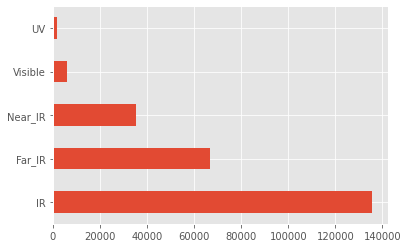

In [ ]:
# To check the number of wavelength of each category type
df.wl_binned.value_counts().plot(kind= 'barh')

In [ ]:
df.shape

(245286, 5)

## Splitting the Raw Data
*Creating Input features (attributes) and Target Vectors for Training and testing the ML model.*

In [ ]:
x = df.drop('book', axis=1) # Input features (attributes)
y = df['book']   # Taget Vector

print('X shape: {}'.format(np.shape(x)))
print('Y shape: {}'.format(np.shape(y)))

X shape: (245286, 4)
Y shape: (245286,)


*`75%` data is for training and `25%` data is for testing.*

In [ ]:
#split the data for training and testing
from sklearn.metrics import accuracy_score,classification_report
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,random_state=42)

In [ ]:
print('Length of x_test : {}\nLength of y_test : {}\nLength of x_train : {}\nLength of y_train : {}'.format(len(x_test),  len(y_test), len(x_train), len(y_train)))

Length of x_test : 61322
Length of y_test : 61322
Length of x_train : 183964
Length of y_train : 183964


### Random Forest Binning

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [ ]:
df.sample()

,book,wl,n,k,wl_binned
50361,diisopropylaminoethanol,5.50308,1.42417,0.000407,Far_IR


In [ ]:
numeric_features = ['wl','n','k']

In [ ]:
#preprocessing and training pipeline with binning

numeric_transformer = Pipeline(steps=[
                                      ('scaler', StandardScaler()),
                                      ('binning',KBinsDiscretizer(n_bins=10,encode='onehot')) #apply binning in 10 groups and one hot encode them
                                      ])

preprocessor = ColumnTransformer(
    transformers=[
                  ('numeric', numeric_transformer, numeric_features)   #apply the transformation
                  ]) 

pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',RandomForestClassifier())
           ])

In [ ]:
#model
rf_model = pipeline.fit(x_train, y_train)
print (rf_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('binning',
                                                                   KBinsDiscretizer(n_bins=10))]),
                                                  ['wl', 'n', 'k'])])),
                ('regressor', RandomForestClassifier())])


In [ ]:
# You can check the training and testing accuracy down below of the df1 dataset
print(f'Training accuracy {rf_model.score(x_train,y_train)}')
print(f'Test accuracy {rf_model.score(x_test,y_test)}')

Training accuracy 0.7000771890152421
Test accuracy 0.6934053031538436


In [ ]:
#predict function for RandomForestClassifier with binning

def predict(lambd,n,k,wl_binned):
  pred_df = pd.DataFrame({'wl':[lambd],
                         'n':[n],
                         'k':[k],
                          'wl_binned': [wl_binned]})
  pred = rf_model.predict(pred_df)
  return f'Book is {pred[0]}'

predict(0.7204,1.3559089944583,0,'IR')

'Book is ethanol'

Accuracy is low, let's see without binning
## Without Binning

In [ ]:
#preprocessing and training pipeline without binning

numeric_transformer = Pipeline(steps=[
                                      ('scaler', StandardScaler()),
                                      ])

preprocessor = ColumnTransformer(
    transformers=[
                  ('numeric', numeric_transformer, numeric_features)   #apply the transformation
                  ]) 

pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',RandomForestClassifier())
           ])

In [ ]:
#model
rf_model_wout_bin = pipeline.fit(x_train, y_train)
print (rf_model_wout_bin)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['wl', 'n', 'k'])])),
                ('regressor', RandomForestClassifier())])


In [ ]:
print(f'Training accuracy {rf_model_wout_bin.score(x_train,y_train)}')
print(f'Test accuracy {rf_model_wout_bin.score(x_test,y_test)}')

Training accuracy 0.959328999152008
Test accuracy 0.8864844590848309


Accuracy has improved a lot

In [ ]:
#predict function for RandomForestClassifier without binning

def predict(lambd,n,k, wl_binned):
  pred_df = pd.DataFrame({'wl':[lambd],
                         'n':[n],
                         'k':[k],
                          'wl_binned': [wl_binned]})
  pred = rf_model_wout_bin.predict(pred_df)
  return f'Book is {pred[0]}'

predict(0.7204,1.3559089944583,0,"Visible")

'Book is acetone'

### accuracies of individual wavelengths:

In [ ]:
UV = x_test[x_test.wl_binned== 'UV']
UV_y = y_test[x_test.wl_binned== 'UV']
Visible = x_test[x_test.wl_binned== "Visible"]
Visible_y = y_test[x_test.wl_binned == "Visible"]
Near_IR = x_test[x_test.wl_binned== 'Near_IR']
Near_IR_y = y_test[x_test.wl_binned== 'Near_IR']
IR = x_test[x_test.wl_binned== 'IR']
IR_y = y_test[x_test.wl_binned== 'IR']
Far_IR = x_test[x_test.wl_binned== 'Far_IR']
Far_IR_y = y_test[x_test.wl_binned== 'Far_IR']

In [ ]:
# Finding the accuracy for each Wavelength Type
labls = ['UV', 'Visible', 'Near_IR', 'IR', 'Far_IR']
tr_scores = []

for l in labls:
    train_x = x_train[x_train.wl_binned == l]
    train_y = y_train[x_train.wl_binned == l]

    tr_scores.append(rf_model_wout_bin.score(train_x, train_y))

In [ ]:
# Accuracy on the bases of Wavelength Category:
for i in range(len(labls)):
    print(labls[i],':', tr_scores[i])

UV : 0.98544061302682
Visible : 1.0
Near_IR : 0.9999624314373732
IR : 0.9272111055281332
Far_IR : 0.998521655745565


In [ ]:
tr_scores

[0.98544061302682,
 1.0,
 0.9999624314373732,
 0.9272111055281332,
 0.998521655745565]

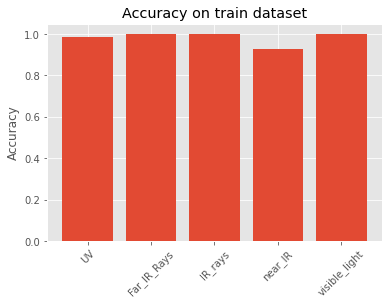

In [ ]:
labls = ['UV','Far_IR_Rays','IR_rays',"near_IR",'visible_light']
plt.bar(labls,tr_scores)
plt.title('Accuracy on train dataset')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Finding the accuracy for each Wavelength Type
labls = ['UV', 'Visible', 'Near_IR', 'IR', 'Far_IR']
scores = []

for l in labls:
    test_x = x_test[x_test.wl_binned == l]
    test_y = y_test[x_test.wl_binned == l]

    scores.append(rf_model_wout_bin.score(test_x, test_y))

In [ ]:
# Accuracy on the bases of Wavelength Category:
for i in range(len(labls)):
    print(labls[i],':', scores[i])

UV : 0.767590618336887
Visible : 0.8520749665327979
Near_IR : 0.9920706841866788
IR : 0.8301630835471409
Far_IR : 0.9517506918541692


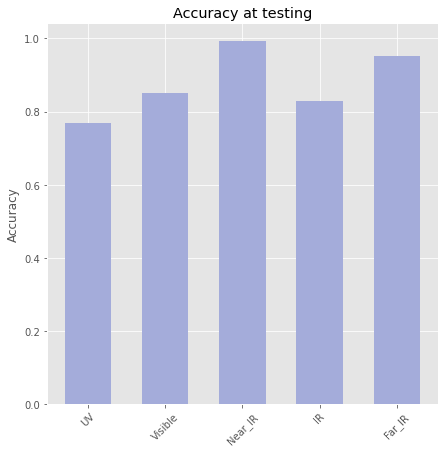

In [ ]:
plt.figure(figsize = (7,7))
plt.bar(labls,scores, color= "#A4ACDA", width = 0.6)

plt.title('Accuracy at testing')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Test instances : UV
print(UV[10:12])
print('-'*90, end='\n\n')
print('Actual Class\n\n', UV_y[10:12])
print('-'*90, end='\n\n')
print('Predicted class\n\n', rf_model_wout_bin.predict(UV[10:12]))

           wl         n    k wl_binned
88318  0.3857  1.388975  0.0        UV
34920  0.3943  1.439902  0.0        UV
------------------------------------------------------------------------------------------

Actual Class

 88318    Ethyl acetate
34920      Cyclohexane
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['Hexane' 'Cyclohexane']


In [ ]:
# Testing it with Visible
print(Visible[10:12])
print('-'*90, end='\n\n')
print('Actual Class\n\n', Visible_y[10:12])
print('-'*90, end='\n\n')
print('Predicted class\n\n', rf_model_wout_bin.predict(Visible[10:12]))

            wl         n    k wl_binned
34792   0.5391  1.405129  0.0   Visible
156339  0.6154  1.345898  0.0   Visible
------------------------------------------------------------------------------------------

Actual Class

 34792     Cyclohexane
156339        pentane
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['Cyclohexane' 'pentane']


In [ ]:
# Test instance : Near_IR
print(Near_IR[10:12])
print('-'*90, end='\n\n')
print('Actual Class\n\n', Near_IR_y[10:12])
print('-'*90, end='\n\n')
print('Predicted class\n\n', rf_model_wout_bin.predict(Near_IR[10:12]))

             wl        n         k wl_binned
238904  1.49732  1.54738  0.000002   Near_IR
38820   1.35473  1.42858  0.000032   Near_IR
------------------------------------------------------------------------------------------

Actual Class

 238904           trichlorobenzene
38820     diisopropylaminoethanol
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['trichlorobenzene' 'diisopropylaminoethanol']


In [ ]:
# Test instance : IR
print(IR[10:12])
print('-'*90, end='\n\n')
print('Actual Class\n\n', IR_y[10:15])
print('-'*90, end='\n\n')
print('Predicted class\n\n', rf_model_wout_bin.predict(IR[10:15]))

             wl        n         k wl_binned
133834  2.57013  1.42193  0.000309        IR
97492   1.86001  1.30886  0.000034        IR
------------------------------------------------------------------------------------------

Actual Class

 133834       octane
97492      Methanol
147045    oxathiane
76200       ethanol
231830      toluene
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['diisopropylaminoethanol' 'Methanol' 'oxathiane' 'ethanol' 'toluene']


In [ ]:
# Test instance : Far_IR
print(Far_IR[10:12])
print('-'*90, end='\n\n')
print('Actual Class\n\n', Far_IR_y[10:15])
print('-'*90, end='\n\n')
print('Predicted class\n\n', rf_model_wout_bin.predict(Far_IR[10:15]))

            wl        n        k wl_binned
159238  6.6100  1.42300  0.01086    Far_IR
167428  9.1931  1.28201  0.73600    Far_IR
------------------------------------------------------------------------------------------

Actual Class

 159238    poly(methyl_methacrylate)
167428         polydimethylsiloxane
15067                  acetonitrile
248438             trichlorobenzene
71566                       ethanol
Name: book, dtype: object
------------------------------------------------------------------------------------------

Predicted class

 ['poly(methyl_methacrylate)' 'polydimethylsiloxane' 'acetonitrile'
 'trichlorobenzene' 'ethanol']


**All of our predictions are correct**

In [ ]:
y_pred = rf_model_wout_bin.predict(x_test)
print(y_pred)

['trichlorobenzene' 'acetonitrile' 'diisopropylaminoethanol' ...
 'polydimethylsiloxane' 'diisopropylaminoethanol' 'polydimethylsiloxane']


### Precision, Recall, F1-Score of this model

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                                         precision    recall  f1-score   support

(C2ClF3)n - polychlorotrifluoroethylene       0.14      0.17      0.15         6
           (C6H12)n - polymethylpentene       0.20      0.20      0.20        10
                              Acetylene       1.00      1.00      1.00        27
                            Cyclohexane       0.84      0.73      0.78       128
                          Ethyl acetate       0.33      0.09      0.14        35
                               Ethylene       1.00      1.00      1.00        24
                                Heptane       0.80      0.88      0.84        86
                                 Hexane       0.68      0.82      0.74        96
                               Methanol       0.90      0.90      0.90      3904
                 Pentanol, amyl alcohol       0.94      0.90      0.92        49
                            acetic_acid       0.87      0.41      0.55        32
                           

## Confusion Matrix

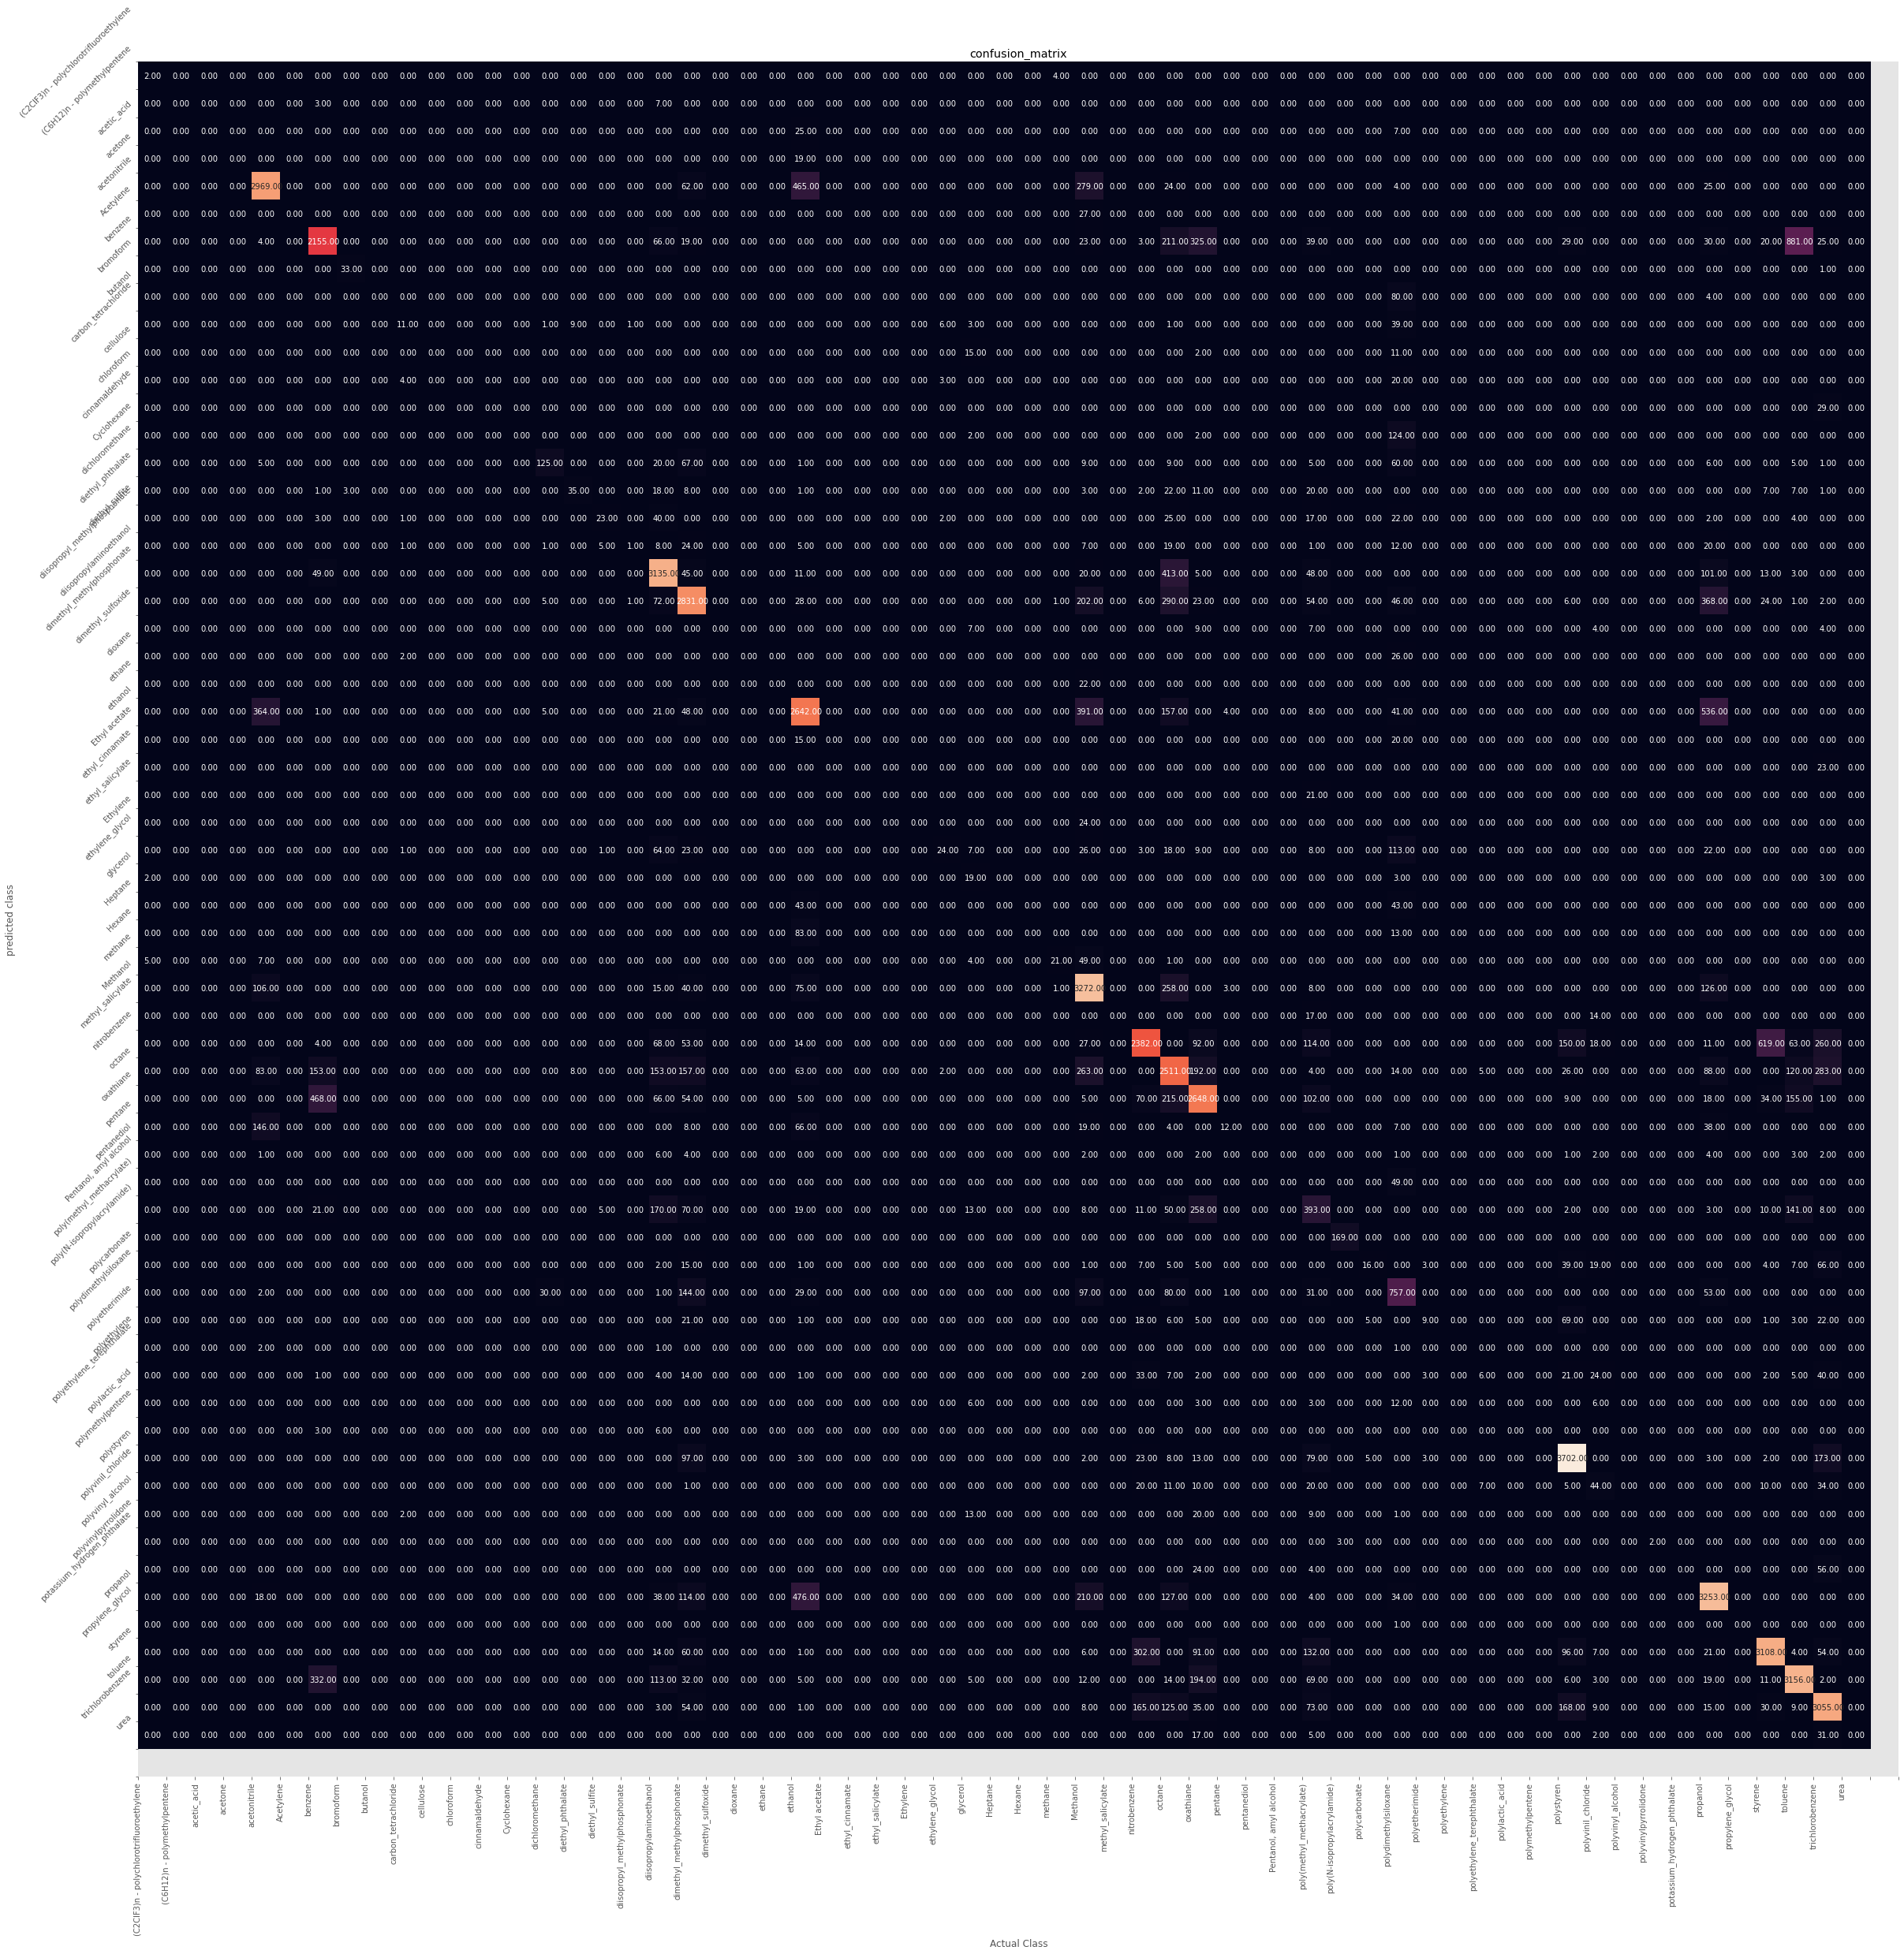

In [ ]:
pred = rf_model.predict(x_test)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(40,40))
cm = confusion_matrix(y_test,pred,labels=list(df.book.unique()))
sns.heatmap(cm,annot=True,fmt='.2f',cbar=False)
plt.xticks(range(0,63),labels=list(df.book.unique()),rotation=90)
plt.yticks(range(0,63),labels=list(df.book.unique()),rotation=45)
plt.title('confusion_matrix')         #checking the confusion matrix
plt.xlabel('Actual Class')
plt.ylabel('predicted class')
plt.show()

ROUND-OFF

In [ ]:
df.head()

,book,wl,n,k,wl_binned
0,(C2ClF3)n - polychlorotrifluoroethylene,0.0900,1.196,0.6096,UV
1,(C2ClF3)n - polychlorotrifluoroethylene,0.0900,1.209,0.6501,UV
2,(C2ClF3)n - polychlorotrifluoroethylene,0.0900,1.228,0.7096,UV
3,(C2ClF3)n - polychlorotrifluoroethylene,0.0900,1.235,0.7315,UV
4,(C2ClF3)n - polychlorotrifluoroethylene,0.1012,1.417,0.4472,UV


In [ ]:
new_df = df.copy()
new_df.drop('wl_binned',axis=1,inplace=True)

In [ ]:
#preprocessing and training pipeline with our own bins

numeric_transformer = Pipeline(steps=[
                                      ('scaler', StandardScaler())
                                      ])


preprocessor = ColumnTransformer(
    transformers=[
                  ('numeric', numeric_transformer, numeric_features),   #apply the transformation
                  ]) 

pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',RandomForestClassifier())
           ])

In [ ]:
#split the data for training and testing

acc_tr = []
acc_ts = []

recall = []

round_place = [1,2,3,4,5]

for r in round_place:
  y = new_df['book']
  x = new_df.drop('book',axis=1).round(r)   #rounding off
  x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,random_state=42)
  rf_model = pipeline.fit(x_train,y_train)
  acc_tr.append(rf_model.score(x_train,y_train))
  acc_ts.append(rf_model.score(x_test,y_test))

  pred = rf_model.predict(x_test)

  recall.append(recall_score(y_test,pred,average='weighted'))

In [ ]:
acc_tr,acc_ts,recall

([0.34188754321497683,
  0.8228457741732078,
  0.9524472179339436,
  0.9588125937683459,
  0.959328999152008],
 [0.31029646782557646,
  0.7621245230096866,
  0.8854081732494048,
  0.8841361990802649,
  0.8848537229705489],
 [0.31029646782557646,
  0.7621245230096866,
  0.8854081732494048,
  0.8841361990802649,
  0.8848537229705489])

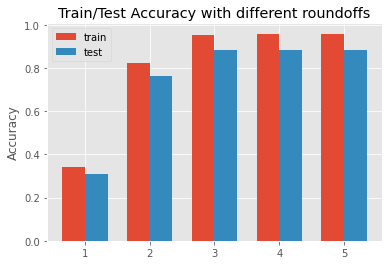

In [ ]:
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
plt.title('Train/Test Accuracy with different roundoffs')
X_axis = np.arange(len(round_place))
ax.bar(X_axis - width/2,acc_tr,width,label='train')
ax.bar(X_axis + width/2,acc_ts,width,label='test')
plt.xticks(X_axis,round_place)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

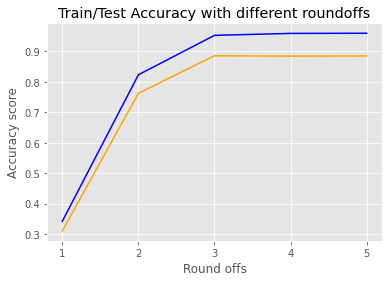

In [ ]:
plt.title('Train/Test Accuracy with different roundoffs')
plt.plot(X_axis,acc_tr,color='b',label ='train')
plt.plot(X_axis,acc_ts,color='orange',label='test')
plt.xlabel('Round offs')
plt.ylabel('Accuracy score')
plt.xticks(range(len(round_place)),round_place)
plt.show()

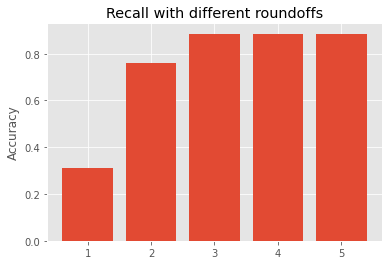

In [ ]:
plt.bar(round_place,recall)
plt.title('Recall with different roundoffs')
plt.ylabel('Accuracy')
plt.show()